# Introduction 

This dataset contains information about used cars.

This data can be used for a lot of purposes such as price prediction to exemplify the use of linear regression in Machine Learning.
The columns in the given dataset are as follows:

* name
* year
* selling_price
* km_driven
* fuel
* seller_type
* transmission
* Owner
* engine
* seat

This is a regression problem. We will try using XGBoost regressor to solve this problem statement. We will see that we have less <100k sample of training data. 

In [100]:
# General imports
from pathlib import Path
import datetime

# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# ML imports
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# I like to disable my Notebook Warnings.
import warnings
warnings.filterwarnings('ignore')

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

# Allows us to see more information regarding the DataFrame
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

# Importing Data
1. Since data is in form of csv file we have to use pandas read_csv to load the data
2. After loading it is important to check the complete information of data. It is important to get a general feel of the data that we are going to be using.

In [101]:
car_data_df = pd.read_csv('/Users/sojasingarayar/Documents/Projet IA/Test/AQSONE_Practice_Test_DS_V3_Dataset_A - AQSONE_Practice_Test_DS_V3_Dataset_A.csv')


In [102]:
car_data_df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,engine,seats
0,Maruti Swift Dzire VDI,2014,6164,145500,Diesel,Individual,Manual,First Owner,1248 CC,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,5068,120000,Diesel,Individual,Manual,Second Owner,1498 CC,5.0
2,Honda City 2017-2020 EXi,2006,2164,140000,Petrol,Individual,Manual,Third Owner,1497 CC,5.0
3,Hyundai i20 Sportz Diesel,2010,3082,127000,Diesel,Individual,Manual,First Owner,1396 CC,5.0
4,Maruti Swift VXI BSIII,2007,1781,120000,Petrol,Individual,Manual,First Owner,1298 CC,5.0


So we have 8 feature columns + 1 target column `selling_price`

<div class="alert alert-block alert-info">
<b>Tip:</b> We can use the <b>.shape</b> attribute to obtain the # of rows and columns of the DataFrame. This is great to do when you import your data to understand how many sample and features we have.
</div>

In [103]:
car_data_df.shape

(8128, 10)

We see that we have 8128 samples (not alot, but this dataset is mostly to practice fundamentals) and `9 feature + 1 target =10 columns`.

# EDA/Visualizations
The goal is to try and gain insights from the data prior to modeling

## Explorating the Dataframe

It is useful to use .info() method to quickly have a glance on the general information about the DataFrame. It displays info such as the type of the columnd and also the # of non-null count. In this case there are 301entries and for each coloumn we have 301 non-null count. This means no column has any missing values.

In [104]:
car_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   engine         7907 non-null   object 
 9   seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 635.1+ KB


The .dtypes attribute allows you to quickly understand what datatype is each column.

In [105]:
car_data_df.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
engine            object
seats            float64
dtype: object

In our case, the datatypes are as expected. We do not have something like the selling price being a String (object).

The describe() method gives a quick summary of the statistical information of the numerical columns. We get descriptions for the mean, standard deviation and max value for example.

In [106]:
car_data_df.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8128.000000,8.128000e+03,7907.000000
mean,2013.804011,8743.468135,6.981951e+04,5.416719
std,4.044249,11044.559233,5.655055e+04,0.959588
min,1983.000000,411.000000,1.000000e+00,2.000000
25%,2011.000000,3493.000000,3.500000e+04,5.000000
50%,2015.000000,6164.000000,6.000000e+04,5.000000
75%,2017.000000,9247.000000,9.800000e+04,5.000000
max,2020.000000,136986.000000,2.360457e+06,14.000000


## Getting all column types
Some features are numerical and others are categorical. Depending on the type, different techniques will have to be used to take care of them. We are going to use a function to generate us the list of columns.

In [107]:
def get_all_cols(df, target_col, exclude=[]):
    
    # Select categorical columns
    object_cols = [cname for cname in df.columns 
                   if df[cname].dtype == "object"]

    # Select numerical columns
    num_cols = [cname for cname in df.columns 
                if df[cname].dtype in ['int64', 'float64', 'uint8']]
    
    all_cols = object_cols + num_cols
    
    exclude_cols = exclude + [target_col]
    
    feature_cols = [col for col in all_cols if col not in exclude_cols]
    
    return object_cols, num_cols, feature_cols

In [108]:
object_cols, num_cols, feature_cols = get_all_cols(car_data_df, "selling_price")

<div class="alert alert-block alert-warning">  
<b>Note:</b> We exlude <b>Selling_Price</b> because it is the target.
</div>

In [109]:
print(object_cols)
print(num_cols)      # Note that num cols does contain the Target column
print(feature_cols)  # Note that feature cols does not contain the Target column

['name', 'fuel', 'seller_type', 'transmission', 'owner', 'engine']
['year', 'selling_price', 'km_driven', 'seats']
['name', 'fuel', 'seller_type', 'transmission', 'owner', 'engine', 'year', 'km_driven', 'seats']


After getting all the categorical columns, let's quickly analyze how many unique values each column takes. This is important to analyze if we want to later on one hot encode a column. A column with 10000 unique values will be very heavy to one hot encode, since it will add `10000-1=9999` new columns.

In [110]:
for object_col in object_cols:
    print(f'{object_col}:{car_data_df[object_col].nunique()}\n')

name:2058

fuel:4

seller_type:3

transmission:2

owner:5

engine:121



In our case, it doesn't seem to bad. Worst case, after testing, we can choose to remove the `name` one hot encoding.

We can also check the count of each category for a column. We do this using the .value_counts() method.

In [111]:
for object_col in object_cols:
    obj_val_counts = car_data_df[object_col].value_counts()
    print(f'{obj_val_counts}\n')

Maruti Swift Dzire VDI                   129
Maruti Alto 800 LXI                       82
Maruti Alto LXi                           71
BMW X4 M Sport X xDrive20d                62
Maruti Swift VDI                          61
                                        ... 
Volkswagen Passat 2.0 TDI AT Highline      1
Honda City 1.5 V MT Exclusive              1
Tata Tiago 1.2 Revotron XM Option          1
Toyota Land Cruiser Prado VX L             1
Datsun GO Anniversary Edition              1
Name: name, Length: 2058, dtype: int64

Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: fuel, dtype: int64

Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: seller_type, dtype: int64

Manual       7078
Automatic    1050
Name: transmission, dtype: int64

First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64

1248 CC    1017
1197 CC     8

## Plotting
We will explore various plots that could give us valuable insights.

### Set the plot styles
Some configurations for the plots to make them look nicer.

In [112]:
colors = sns.color_palette('pastel') # Color palette to use
sns.set(rc={'figure.figsize':(8,6)})
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
sns.set_style('white') # darkgrid, white grid, dark, white and ticks

## Bar Plot
Here we will explore the amount the selling price per fuel type. Goal would be to determine the correlation between the category types to selling price.

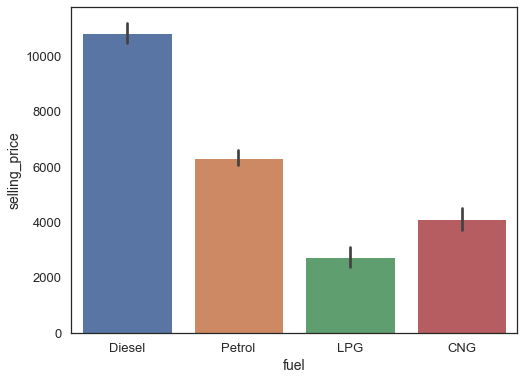

In [113]:
sns.barplot(data=car_data_df, x='fuel', y='selling_price');

It is clear from this plot that diesel cars sell for a higher price. This is expected since diesel fuel is more expensive normally.

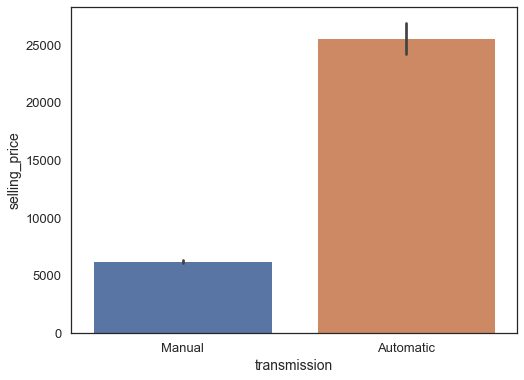

In [114]:
sns.barplot(data=car_data_df, x='transmission', y= 'selling_price');

It is clear from this plot that automatic cars sell for a higher price. This is expected since historically automatic car have been sold for a higher price.

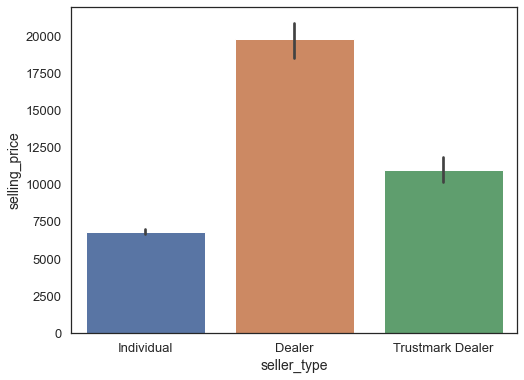

In [115]:
sns.barplot(data=car_data_df, x='seller_type', y= 'selling_price');

<AxesSubplot:xlabel='year'>

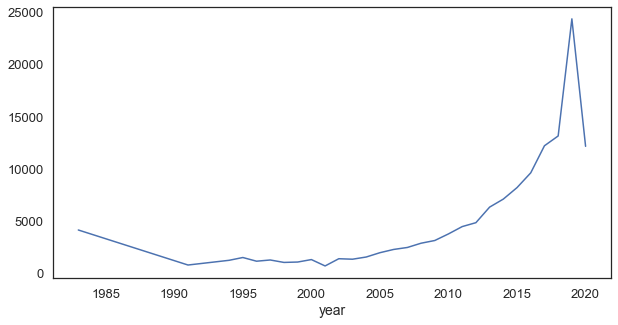

In [116]:
car_df_grouped_by_year = car_data_df.groupby(['year'])['selling_price'].mean()
car_df_grouped_by_year.plot(figsize = (10,5))

This plot showcases the steady increase of car selling price througout the years. This is expected especially with inflation.

## Categorical Plot
Here we will explore the amount of sell, mean and distribution per product. We can look at distribution and see if it close to being a Gaussian distribution and also look at if there are any outliers. Goal would be to analyze the statistical distribution of num_sold depending on each product type.

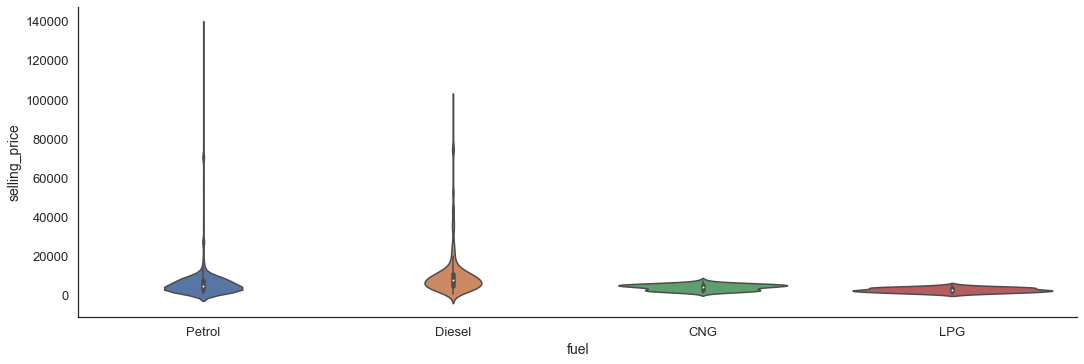

In [117]:
sns.catplot(x='fuel', y= 'selling_price', data = car_data_df.sort_values("selling_price", ascending = False), kind="violin", height = 5, aspect = 3)
plt.show()

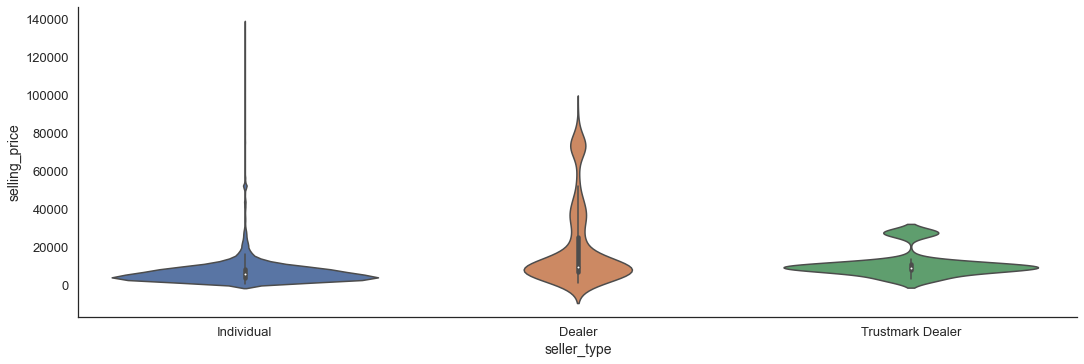

In [118]:
sns.catplot(x='seller_type', y= 'selling_price', data = car_data_df.sort_values("selling_price", ascending = False), kind="violin", height = 5, aspect = 3)
plt.show()

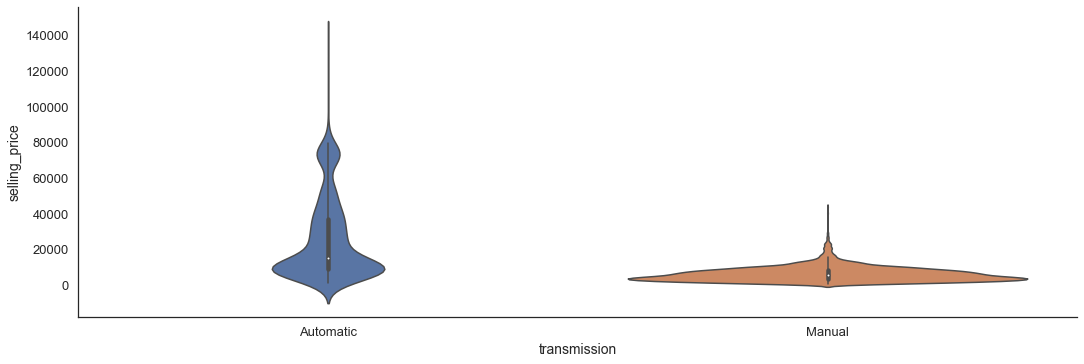

In [119]:
sns.catplot(x='transmission', y= 'selling_price', data = car_data_df.sort_values("selling_price", ascending = False), kind="violin", height = 5, aspect = 3)
plt.show()

These categorical plots re-inforce what we discovered with the bar plots. They also gives us a quick look at the probability distribution of each category. A lot of them do not follow a gaussian distribution, but that is okay in our case since we will be using XGBoost. Scaling and transforming is espcially important for algorithms that use gradient descent or a distance based learning such as KNN.

<div class="alert alert-block alert-success">  
<b>What we found:</b> From the EDA, we notice that we do not have any missing data. We also notice we have a year column that we can transform into a year_old column. 
</div>

# Feature Engineering
In this section, we take the data and preprocess and engineer it so that it is ready to be fed to our model. There are many steps to this.

## Prepare the Data
In this subsection, we look into preparing the feature columns. That can be done by transforming the type of the column to a proper one, creating datetime features from our date column or even adding more valuable feature column (such as holidays) to our dataframe. This is the first step before going to other feature engineering steps.

In [120]:
TARGET = 'selling_price'

now = datetime.datetime.now()
car_data_df["Year_Old"] = now.year - car_data_df["year"]
car_data_df.drop(["year"],axis=1, inplace=True)

In [121]:
car_data_df.head()

,name,selling_price,km_driven,fuel,seller_type,transmission,owner,engine,seats,Year_Old
0,Maruti Swift Dzire VDI,6164,145500,Diesel,Individual,Manual,First Owner,1248 CC,5.0,8
1,Skoda Rapid 1.5 TDI Ambition,5068,120000,Diesel,Individual,Manual,Second Owner,1498 CC,5.0,8
2,Honda City 2017-2020 EXi,2164,140000,Petrol,Individual,Manual,Third Owner,1497 CC,5.0,16
3,Hyundai i20 Sportz Diesel,3082,127000,Diesel,Individual,Manual,First Owner,1396 CC,5.0,12
4,Maruti Swift VXI BSIII,1781,120000,Petrol,Individual,Manual,First Owner,1298 CC,5.0,15


## Handling Missing Values 
In this subsection, we look if we have any missing data, if so, we take care of it. We already saw beforehand that there is no missing data, but I wanted to show this chain of funcitons that can quickly give you the amount of missing values for each column.

In [122]:
car_data_df.isna().sum()

name               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
engine           221
seats            221
Year_Old           0
dtype: int64

In [123]:
def dist_plots(df):
    plt.figure(figsize=(10,5))
    plt.title("Distribution Plot")
    sns.distplot(df)
    sns.despine()
    plt.show()

4.193545072435777


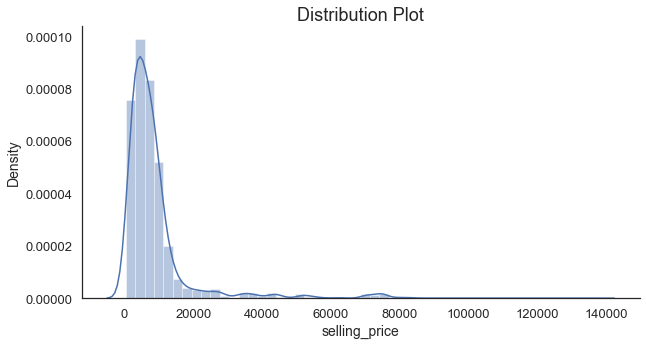

In [124]:
print(car_data_df[TARGET].skew())
dist_plots(car_data_df[TARGET])

We notice that the distributiuon is right skewed. Let's try to fix this using log transformation

Here we are defining a function that takes care of the log transform of a column.

In [125]:
def transform_target(df, target):
    """
    Apply a log transformation to the target for better optimization 
    during training.
    """
    df[target] = np.log(df[target])
    return df

car_data_df = transform_target(car_data_df, TARGET)

0.2231776462017017


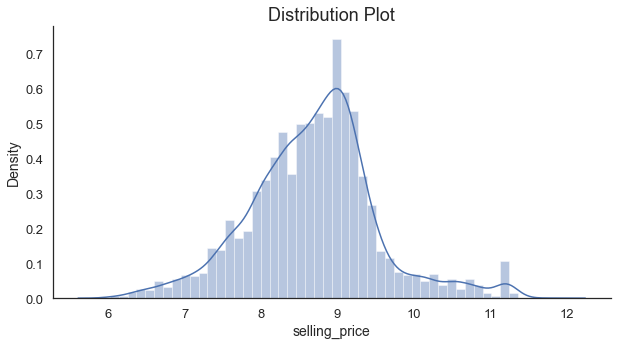

In [126]:
print(car_data_df[TARGET].skew())
dist_plots(car_data_df[TARGET])

## Handling Categorical Data
So that the model can understand categorical data, we must transform them in a numerical form. There is various ways to do that. 

Some of them categorical data are,
<div class="alert alert-block alert-info">
<b>Nominal Data</b> --> data are not in any order --> OneHotEncoder is used in this case
</div>
<div class="alert alert-block alert-info">
<b>Ordinal data </b> --> data are in order --> LabelEncoder is used in this case
</div>

Since all our columns are of the nominal type, we are going to use one hot encoding. To do so, we are defining a function that uses get_dummies() method to one hot encode our categorical data.

In [127]:
# Convert the Categorical variables to one-hot encoded features...
# It will help in the training process
def create_one_hot(df, categ_colums):
    """
    Creates one_hot encoded fields for the specified categorical columns...
    Args
        df
        categ_colums
    Returns
        df
    """
    df = pd.get_dummies(df, columns=categ_colums)
    return df

Let's get all numerical and categorical columns. We have to call our function again since we've been prepraring the data and adding/removing/transforming columns.

In [128]:
object_cols, num_cols, feature_cols = get_all_cols(car_data_df, "selling_price")

In [129]:
car_data_df = create_one_hot(car_data_df, object_cols)

## Feature Selection

Finding out the best feature which will contribute and have good relation with target variable.
Following are some of the feature selection methods,


<div class="alert alert-block alert-info">
<b>1. heatmap</b> 
</div>
<div class="alert alert-block alert-info">
<b>2. feature_importance_</b> 
</div>
<div class="alert alert-block alert-info">
<b>3. SelectKBest</b> 
</div>

In [130]:
object_cols, num_cols, feature_cols = get_all_cols(car_data_df, "selling_price")

In [131]:
feature_cols_plus_target = [TARGET] + feature_cols

<div class="alert alert-block alert-warning">  
<b>Note:</b> We are filtering uptil the 4th column since after , it is the one hot encoded features. I decided to not plot those since the heatmap will
    be too dense.
</div>

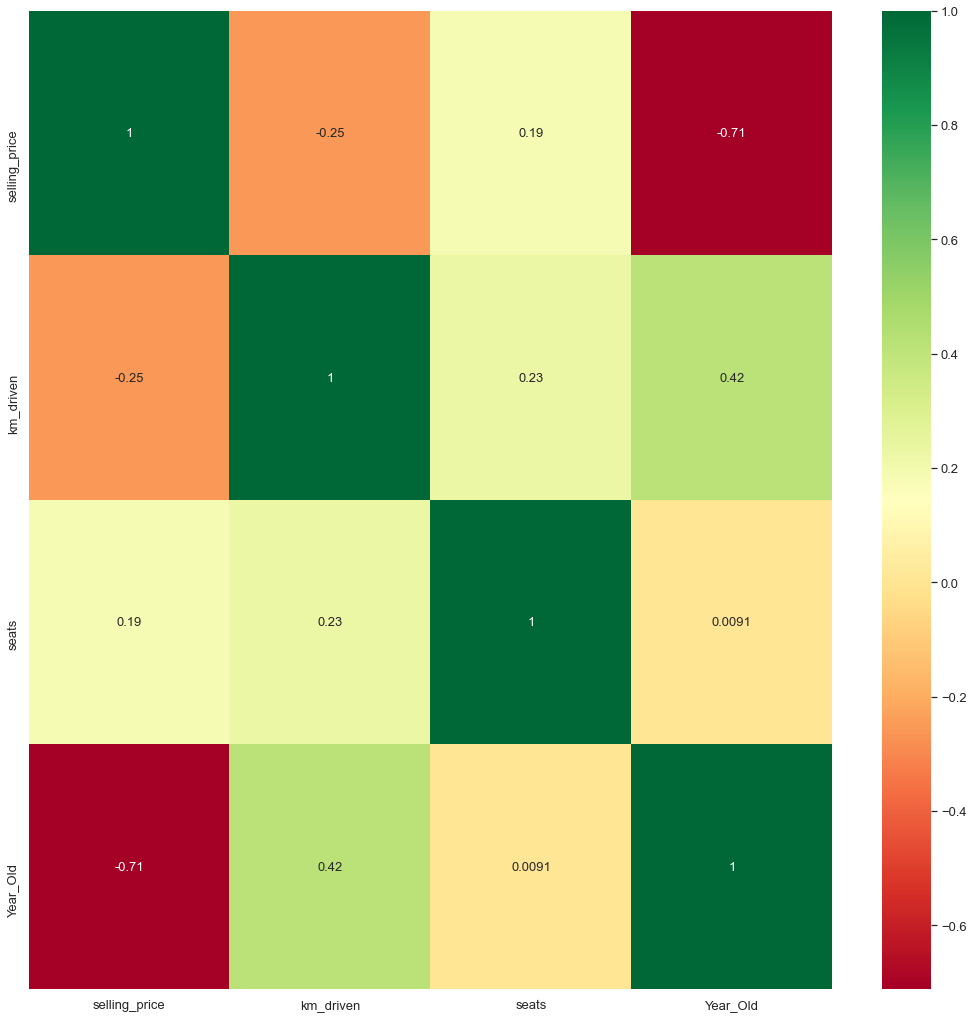

In [132]:
heatmap_df = car_data_df[feature_cols_plus_target].iloc[:,:4]

plt.figure(figsize = (18,18))
sns.heatmap(heatmap_df.corr(), annot = True, cmap = "RdYlGn")

plt.show()

**We notice what has the highest effect on our target variable. We notice:**

The Year_Old has the highest negative correlation with the target variable which also makes sense. The older the car, the more the deterioration thus the lower the price.

### Feature importance (Extra Tree Regressor)
You can also use the ExtraTressRegressor from sklearn which will allows you to easily see what are the important features for the Target Price.


In [133]:
object_cols, num_cols, feature_cols = get_all_cols(car_data_df, "selling_price")

In [134]:
X = car_data_df[feature_cols]
y = car_data_df[TARGET]


    To get the quicker result as because of time constrain we will impute mean value in the place of NaN values

In [135]:
#to fill with mean value
X = X.fillna(X.mean())
#X = np.nan_to_num(X)

In [136]:
# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

You can print it, but it isn't the prettiest.

In [137]:
print(selection.feature_importances_)

[0.01906232 0.02411039 0.30631187 ... 0.00199613 0.00433447 0.00198072]


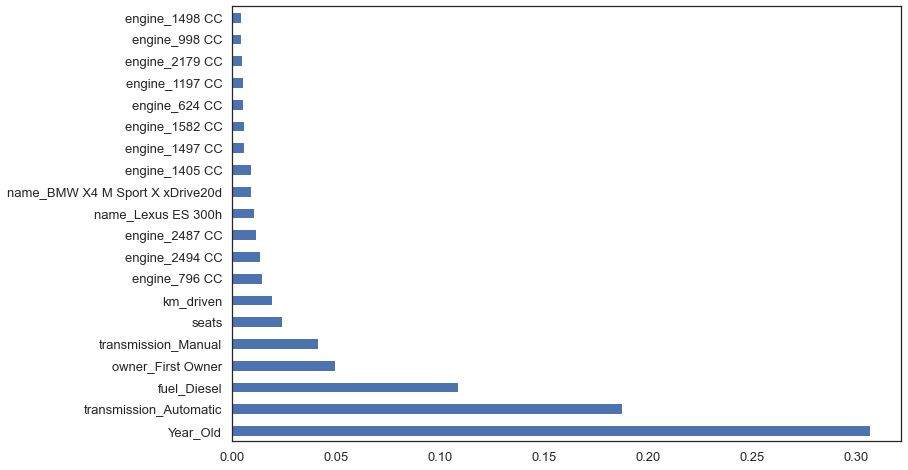

In [138]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

We also notice that the most important feature is the Year_old as found witht heatmap.

From the feature importance plot, it is clear that the most important feature here is the trasmission_automatic, fuel_diesel. (Note that we didn't plot the categorical features with the heatmap). This makes sense since whenever  the car iis automatic and diesel its price is high.


## Splitting the data
In this section, we will split the data in train and test set. Do not confuse test set with our test data. Test set is just a subsample of train_df.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Models
In this section, we will explore two models:

1. RandomForestRegressor
2. XGBRegressor

## Training
We've prepared the food (data), time to... FEED THE MACHINE.

In [140]:
from xgboost import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
xgboost_model = XGBRegressor(n_jobs = -1)

hist_rf_model = rf_model.fit(X_train, y_train)
hist_xgboost_model= xgboost_model.fit(X_train, y_train)

## Predicting
In this subsection, we will use the basic trained model to predict on our test set (not test data).

In [141]:
y_pred_rf = rf_model.predict(X_test)
y_pred_xgboost = xgboost_model.predict(X_test)

In [142]:
print(rf_model.score(X_train, y_train))
print(xgboost_model.score(X_train, y_train))

0.9876352628049585
0.9428001476116428


In [143]:
print(rf_model.score(X_test, y_pred_rf))
print(xgboost_model.score(X_test, y_pred_xgboost))

1.0
1.0


## Evaluating
In this subsection, we evaluate using plots and metrics to see if our predictions are good or not.

### Distribution plots

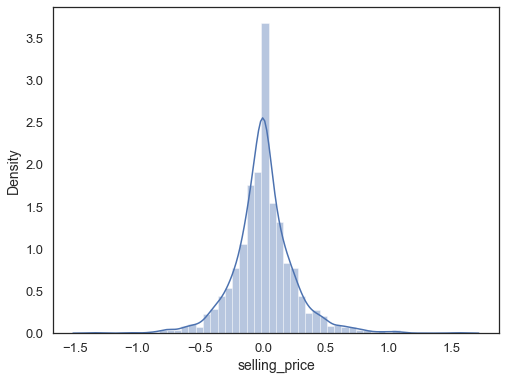

In [144]:
sns.distplot(y_test-y_pred_rf)
plt.show()

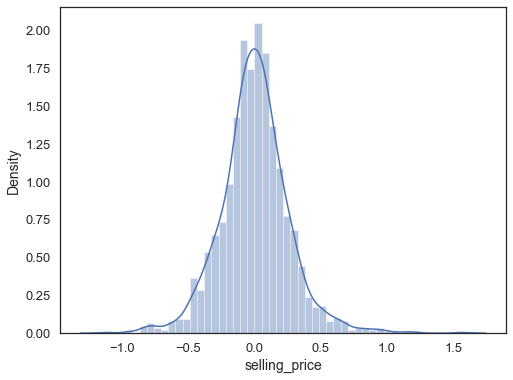

In [145]:
sns.distplot(y_test-y_pred_xgboost)
plt.show()

We notice that the disth plot for the XGBoost seems tigher and a bit less spread. As well the density at 0 is much higher for the XGBoost than the RandomForest. This means there is more predictions for the XGBoost model that is closer to the expected output.

### Scatter plot of Target and Predicted

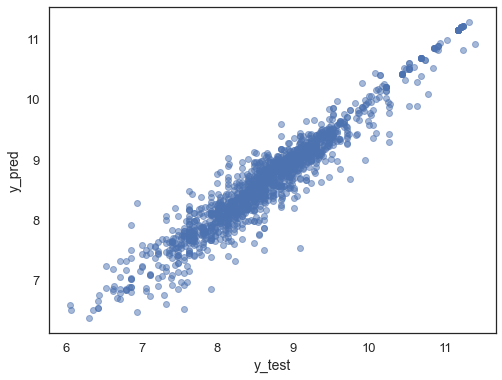

In [146]:
plt.scatter(y_test, y_pred_rf, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

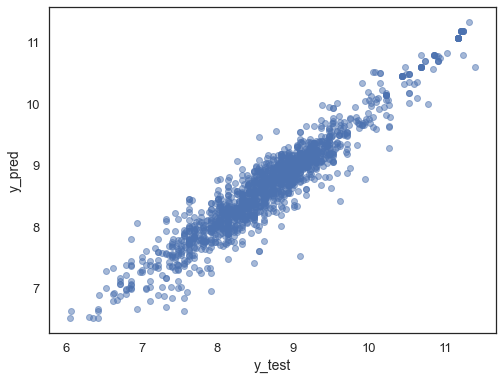

In [147]:
plt.scatter(y_test, y_pred_xgboost, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

We notice that the scatter plot for the XGBoost model is much tighter. The tighter and the more linear this graph is, the more the predicted and expected values are similar. In a perfect model, we would expect this slope to be 1.

### Metrics to decide on which model to use
I have chosen a handful of metrics, however the main one used of regression is usually R2 score.

In [148]:
from sklearn import metrics

In [149]:
print('RandomForest')
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

print('XGBoost')
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_xgboost))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_xgboost))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgboost)))

RandomForest
MAE: 0.1644314244313477
MSE: 0.058658658208209154
RMSE: 0.2421954958462464
XGBoost
MAE: 0.1898554727258005
MSE: 0.06720890753489232
RMSE: 0.2592468081479352


In [150]:
metrics.r2_score(y_test, y_pred_rf)

0.9143760767818412

In [151]:
metrics.r2_score(y_test, y_pred_xgboost)

0.9018952953557571

RandomForest outperformed the  XGBoost on all three metrics. 

But  XGboost can be optimized in order to provide better result the XGBoost model for the hyperparameter tuning.

# Hyperparameter Tuning


* Choose following method for hyperparameter tuning
    1. **RandomizedSearchCV**: Faster when there are many combinations of hyperparameter
    2. **GridSearchCV**: Tries all combinations
* Assign hyperparameters in form of dictionary
* Fit the model
* Check best paramters and best score

In [152]:
from sklearn.model_selection import RandomizedSearchCV

In [156]:
# Create the random grid for the XGBoost model

params = {
 "learning_rate" : [0.05,0.10],#,0.15,0.20,0.25,0.30
 "max_depth" : [ 3, 4],#, 6, 8, 10, 12, 15
 "min_child_weight" : [ 1, 3],#, 5, 7 
 "gamma": [ 0.0, 0.4],#, 0.2 , 0.3, 0.1 
 "colsample_bytree" : [ 0.3, 0.4]#, 0.5 , 0.7 
}

In [154]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
xgb_model_tuned = RandomizedSearchCV(estimator = xgboost_model, param_distributions = params, scoring='neg_mean_squared_error', n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [155]:
# I skip the deep optimization as to  give a simple result in a given time
xgb_model_tuned.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  11.8s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  12.5s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  13.2s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  12.3s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  12.0s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3; total time=  11.7s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3; total time=  13.4s
[CV] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3; total time=  11.3s
[CV] END colsample_bytree=

KeyboardInterrupt: 

In [157]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
xgb_model_tuned = RandomizedSearchCV(estimator = xgboost_model, param_distributions = params, scoring='neg_mean_squared_error', n_iter = 5, cv = 2, verbose=2, random_state=42, n_jobs = 1)

In [158]:
xgb_model_tuned.fit(X_train,y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3; total time=   8.3s
[CV] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=3, min_child_weight=3; total time=   9.4s
[CV] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=3; total time=  12.8s
[CV] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=4, min_child_weight=3; total time=  10.2s
[CV] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=   8.5s
[CV] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  11.5s
[CV] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3; total time=   9.5s
[CV] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3; total time=   9.3s
[CV] END colsample_bytree=0.3, g

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=-1,
                                          num_pa...ee=1, random_state=0,
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_weigh

We can check the best parameters by accessing the following attribute:

In [160]:
xgb_model_tuned.best_params_

# {'min_child_weight': 7,
#  'max_depth': 6,
#  'learning_rate': 0.2,
#  'gamma': 0.1,
#  'colsample_bytree': 0.4}

{'min_child_weight': 3,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 0.4,
 'colsample_bytree': 0.3}

## Predicting with tuned model
Let us used our tuned model to predict the Target price and see if it does better than our untuned model.

In [161]:
prediction = xgb_model_tuned.predict(X_test)

## Evaluating tuned model

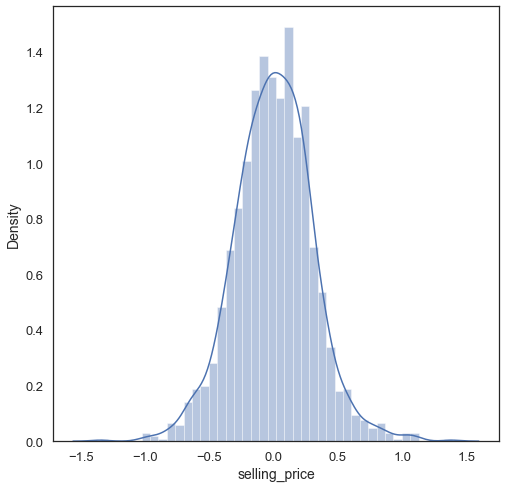

In [162]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

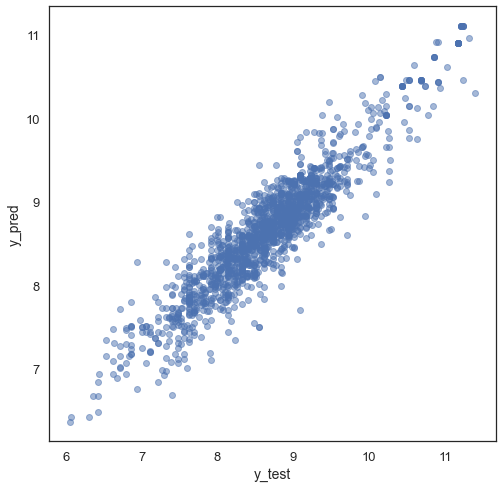

In [163]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [164]:
# XGBoost
# MAE: 0.12520076071530886
# MSE: 0.03371250905578623
# RMSE: 0.1836096649302161

print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 0.23545996255401777
MSE: 0.09214139462260847
RMSE: 0.3035480104079229


In [165]:
# XGBoost
# 0.9999356433552934

metrics.r2_score(y_test, prediction)

0.8655013950306115

We notice from the plots and metrics that the hyper parameter tuning does not have significant improvements on the performance. This is due to the fact that we do not have a time to optimize it!

# Save the model to reuse it again

There's various ways to save the model. We decided to go forward with pickling. It is very easy and straighforward. 

In [166]:
import pickle
# open a file, where you ant to store the data
file = open('xgboost_tuned.pkl', 'wb') # wb is write and binary mode

# dump information to that file
pickle.dump(xgb_model_tuned, file)

In [ ]:
model = open('xgboost_tuned.pkl','rb')
xgboost = pickle.load(model)

In [ ]:
y_prediction = xgboost.predict(X_test)

In [ ]:
metrics.r2_score(y_test, y_prediction)

As you can see, it is extremely easy to save and load a trained model and to use it for future predictions. No need to traine everytime!

# Final Remarks
So the we should try other regression model and do some feature engineering to cross the feature to give more relevant feature to our model in order to get better result.
If have more time then we can do:
* Better fine tue the model in order to get better result.
* More useful Exploratory analysis
* Better feature engineering par ex: Crossingfeature
* Try other algorithm forregression problem

# Thank you!